In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re

In [2]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In [3]:
df['QTY'] = df['QTY'].astype(str)
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

In [4]:
df.keys()

Index(['ITEM_ID', 'DATE_ID', 'STORE_ID', 'CAT_DAYOFWEEK', 'DUM_FREEWEEKDAY',
       'DUM_WORKSATURDAY', 'DUM_SPRINGBREAK', 'DUM_SUMMERBREAK',
       'DUM_FALLBREAK', 'DUM_WINTERBREAK', 'DUM_WORKDAY',
       'NUM_WORKDAYS_THISWEEK', 'NUM_WORKDAYS_PASTWEEK',
       'NUM_WORKDAYS_NEXTWEEK', 'NUM_WORKDAYS_PAST7DAY',
       'NUM_WORKDAYS_FRWD7DAY', 'NUM_HOLIDAY_FROM', 'NUM_HOLIDAY_TO',
       'NUM_HOLIDAY_SNGL_FROM', 'NUM_HOLIDAY_SNGL_TO', 'NUM_HOLIDAY_WHIT_FROM',
       'NUM_HOLIDAY_WHIT_TO', 'NUM_HOLIDAY_XMAS_FROM', 'NUM_HOLIDAY_XMAS_TO',
       'NUM_SCHOOLBREAK_FROM_END', 'NUM_SCHOOLBREAK_TO_START',
       'NUM_SCHOOLBREAK_FROM_START', 'NUM_SCHOOLBREAK_TO_END', 'QTY', 'PRICE',
       'CUSTOMER'],
      dtype='object')

In [5]:
df.ITEM_ID.unique()

array([ 0.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        3., 18.,  1., 15., 19., 16., 17., 20., 21., 22.])

In [6]:
df.STORE_ID.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 49., 48., 53., 50., 56.,
       54., 55., 58., 57., 51., 28., 52., 60., 59.])

In [17]:
df.DATE_ID.unique()

array([  1.,   3.,   4., ...,  79.,  65., 100.])

In [18]:
len(df.DATE_ID.unique())

1219

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

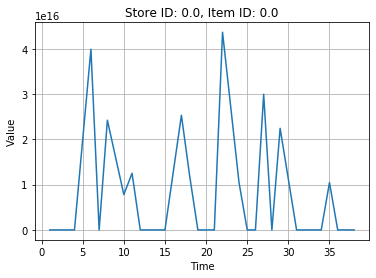

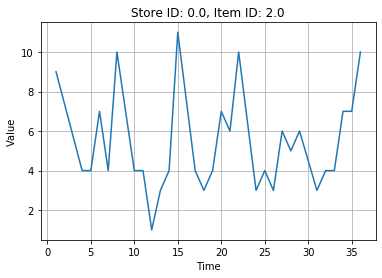

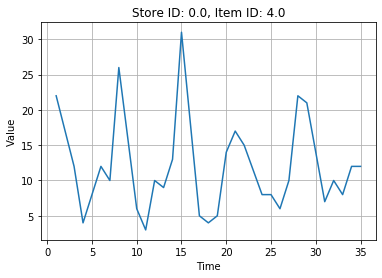

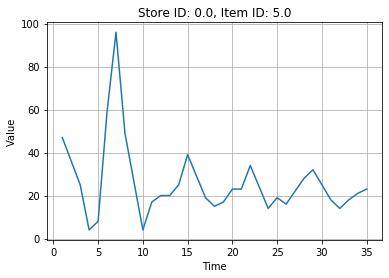

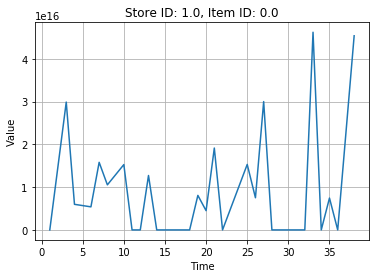

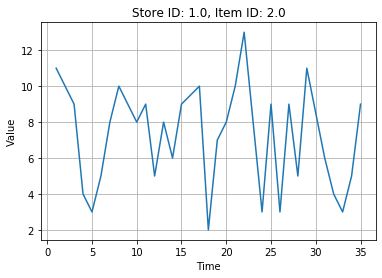

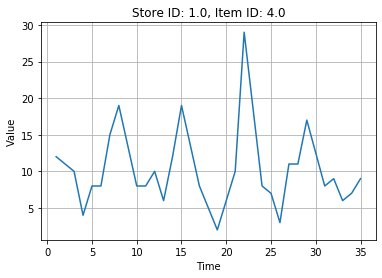

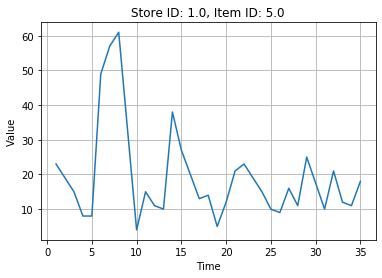

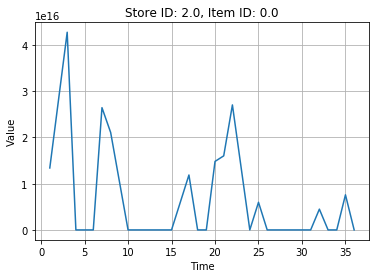

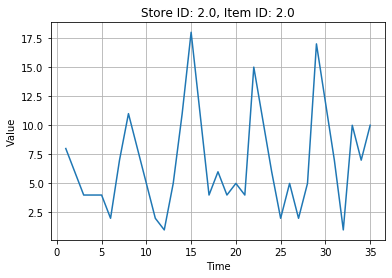

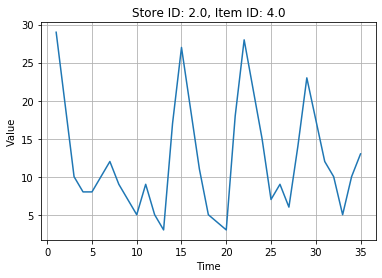

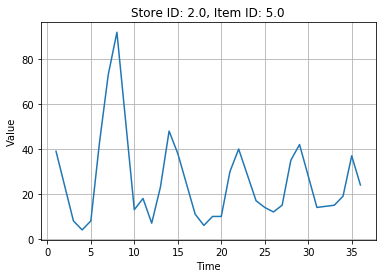

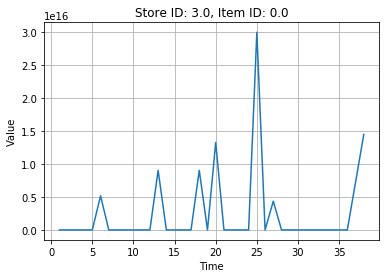

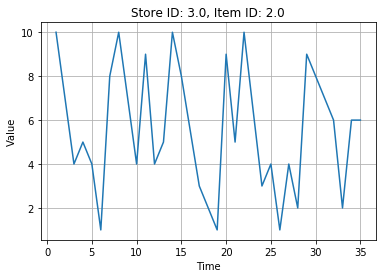

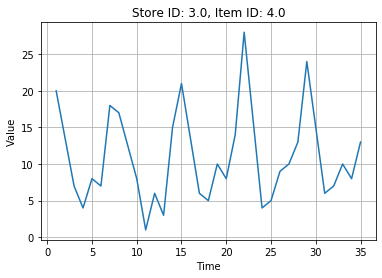

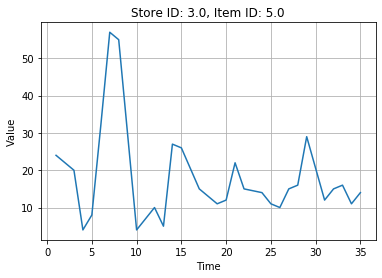

In [19]:
#Having a glimpse
for store in list(df.STORE_ID.unique())[:4]:
    for item in list(df.ITEM_ID.unique())[:4]:
        df_zoom = df[(df.STORE_ID == store)&(df.ITEM_ID==item)]
        ts = df_zoom.groupby(['DATE_ID'])['QTY'].sum().reset_index(name='sum(QTY)')
        time = ts.DATE_ID.values
        series = ts['sum(QTY)'].values
        plt.figure()
        plot_series(time,series,end=30)
        plt.title('Store ID: {}, Item ID: {}'.format(store,item))


In [11]:
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from fbprophet import Prophet # DON'T insall
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor

In [6]:
df['qty_per_customer']=df.QTY/df.CUSTOMER

In [7]:
df['qty_per_customer'].describe()

count    9.796650e+05
mean     3.268917e+11
std      2.481875e+12
min      1.858045e-04
25%      3.278689e-03
50%      6.113537e-03
75%      1.215470e-02
max      1.084086e+14
Name: qty_per_customer, dtype: float64

In [8]:
df['cash_per_customer']=df.PRICE/df.CUSTOMER
df['cash_per_customer'].describe()

count    979665.000000
mean          0.359212
std           0.201908
min           0.041536
25%           0.218652
50%           0.311232
75%           0.444580
max           6.517383
Name: cash_per_customer, dtype: float64

Hier stimmt doch irgendetwas nicht.

In [12]:
for item in list(df.ITEM_ID.unique()):
    print('Item ID: {}'.format(item))
    print(df[df.ITEM_ID==item].QTY.describe(),'\n')

Item ID: 0.0
count    5.764200e+04
mean     7.216562e+15
std      1.343926e+16
min      2.000000e+00
25%      1.231960e+05
50%      1.016405e+06
75%      1.050510e+16
max      7.978100e+16
Name: QTY, dtype: float64 

Item ID: 2.0
count    59632.000000
mean         9.722599
std          7.647604
min          1.000000
25%          4.000000
50%          8.000000
75%         12.000000
max         96.000000
Name: QTY, dtype: float64 

Item ID: 4.0
count    60473.000000
mean        14.220776
std         10.390896
min          1.000000
25%          7.000000
50%         11.000000
75%         18.000000
max        139.000000
Name: QTY, dtype: float64 

Item ID: 5.0
count    60846.000000
mean        23.936956
std         15.866473
min          1.000000
25%         13.000000
50%         20.000000
75%         30.000000
max        238.000000
Name: QTY, dtype: float64 

Item ID: 6.0
count    60959.000000
mean        22.604718
std         13.418770
min          1.000000
25%         13.000000
50%      

In [16]:
df[df.ITEM_ID==17].QTY.min()

3.0

In [18]:
for store in list(df.STORE_ID.unique()):
    for item in list(df.ITEM_ID.unique()):
        #df_zoom = df[(df.STORE_ID == store)&(df.ITEM_ID==item)]
        print('Store ID: {}, Item ID: {}'.format(store,item))
        print(df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.describe(),'\n')

Store ID: 0.0, Item ID: 0.0
count    1.143000e+03
mean     7.022042e+15
std      1.275702e+16
min      1.444000e+03
25%      1.051270e+05
50%      8.759950e+05
75%      1.013887e+16
max      7.783350e+16
Name: QTY, dtype: float64 

Store ID: 0.0, Item ID: 2.0
count    1191.000000
mean        6.837112
std         4.167542
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        49.000000
Name: QTY, dtype: float64 

Store ID: 0.0, Item ID: 4.0
count    1206.000000
mean       13.708126
std         8.460171
min         1.000000
25%         8.000000
50%        11.000000
75%        17.000000
max        59.000000
Name: QTY, dtype: float64 

Store ID: 0.0, Item ID: 5.0
count    1211.000000
mean       26.279934
std        13.069367
min         4.000000
25%        18.000000
50%        24.000000
75%        31.000000
max       131.000000
Name: QTY, dtype: float64 

Store ID: 0.0, Item ID: 6.0
count    1209.000000
mean       19.826303
std         9.659669
min  

count    505.000000
mean       6.073267
std        4.070385
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       29.000000
Name: QTY, dtype: float64 

Store ID: 1.0, Item ID: 16.0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: QTY, dtype: float64 

Store ID: 1.0, Item ID: 17.0
count    4.670000e+02
mean     8.558777e+15
std      1.573125e+16
min      1.178000e+03
25%      1.334940e+05
50%      9.744150e+05
75%      1.169687e+16
max      7.972400e+16
Name: QTY, dtype: float64 

Store ID: 1.0, Item ID: 20.0
count    207.000000
mean      12.347826
std        7.573894
min        1.000000
25%        7.000000
50%       10.000000
75%       16.000000
max       46.000000
Name: QTY, dtype: float64 

Store ID: 1.0, Item ID: 21.0
count    223.000000
mean       9.753363
std        5.458044
min        1.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       35.000000
Name: QTY, d

count    908.000000
mean       9.665198
std       10.797843
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       93.000000
Name: QTY, dtype: float64 

Store ID: 3.0, Item ID: 18.0
count    1032.000000
mean        7.100775
std         7.781916
min         1.000000
25%         3.000000
50%         6.000000
75%         9.000000
max       126.000000
Name: QTY, dtype: float64 

Store ID: 3.0, Item ID: 1.0
count    142.000000
mean       8.443662
std        7.965818
min        1.000000
25%        3.000000
50%        5.000000
75%       12.000000
max       46.000000
Name: QTY, dtype: float64 

Store ID: 3.0, Item ID: 15.0
count    4.900000e+01
mean     8.453709e+15
std      1.367820e+16
min      1.276800e+04
25%      1.021725e+06
50%      4.158245e+06
75%      1.478865e+16
max      4.836545e+16
Name: QTY, dtype: float64 

Store ID: 3.0, Item ID: 19.0
count    486.000000
mean       5.825103
std        3.755994
min        1.000000
25%        3.000000
50%      

count    1213.000000
mean       28.382523
std        14.216226
min         3.000000
25%        18.000000
50%        26.000000
75%        37.000000
max        82.000000
Name: QTY, dtype: float64 

Store ID: 5.0, Item ID: 7.0
count    1210.000000
mean       15.054545
std         8.268069
min         1.000000
25%         9.000000
50%        14.000000
75%        19.000000
max        54.000000
Name: QTY, dtype: float64 

Store ID: 5.0, Item ID: 8.0
count    1171.000000
mean       20.363792
std        12.617618
min         1.000000
25%        11.000000
50%        17.000000
75%        26.000000
max       101.000000
Name: QTY, dtype: float64 

Store ID: 5.0, Item ID: 9.0
count    1211.000000
mean       16.171759
std        10.362930
min         1.000000
25%         9.000000
50%        14.000000
75%        22.000000
max        68.000000
Name: QTY, dtype: float64 

Store ID: 5.0, Item ID: 10.0
count    1210.000000
mean       15.861983
std        10.314971
min         1.000000
25%         9.00000

count    1158.000000
mean       10.296200
std         6.733051
min         1.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        48.000000
Name: QTY, dtype: float64 

Store ID: 7.0, Item ID: 4.0
count    1176.000000
mean       16.570578
std         9.589983
min         1.000000
25%        10.000000
50%        14.000000
75%        21.000000
max        69.000000
Name: QTY, dtype: float64 

Store ID: 7.0, Item ID: 5.0
count    1178.000000
mean       28.548387
std        16.479841
min         3.000000
25%        17.000000
50%        26.000000
75%        35.000000
max       151.000000
Name: QTY, dtype: float64 

Store ID: 7.0, Item ID: 6.0
count    1178.000000
mean       24.774194
std        14.896526
min         1.000000
25%        13.000000
50%        21.000000
75%        33.000000
max        98.000000
Name: QTY, dtype: float64 

Store ID: 7.0, Item ID: 7.0
count    1172.000000
mean       11.407850
std         7.508324
min         1.000000
25%         6.000000

count    506.000000
mean       4.681818
std        3.091916
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       28.000000
Name: QTY, dtype: float64 

Store ID: 8.0, Item ID: 16.0
count    1.000000e+00
mean     1.303400e+16
std               NaN
min      1.303400e+16
25%      1.303400e+16
50%      1.303400e+16
75%      1.303400e+16
max      1.303400e+16
Name: QTY, dtype: float64 

Store ID: 8.0, Item ID: 17.0
count    4.590000e+02
mean     7.275133e+15
std      1.337325e+16
min      3.000000e+00
25%      1.557335e+05
50%      1.092785e+06
75%      9.645350e+15
max      7.049000e+16
Name: QTY, dtype: float64 

Store ID: 8.0, Item ID: 20.0
count    212.000000
mean      10.900943
std        5.703960
min        1.000000
25%        7.000000
50%       10.000000
75%       14.000000
max       34.000000
Name: QTY, dtype: float64 

Store ID: 8.0, Item ID: 21.0
count    216.000000
mean       9.930556
std        4.069146
min        1.000000
25%        7.000000


count    1100.000000
mean        7.274545
std         6.751880
min         1.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        94.000000
Name: QTY, dtype: float64 

Store ID: 10.0, Item ID: 1.0
count    118.000000
mean       9.745763
std        7.664087
min        1.000000
25%        3.000000
50%        8.000000
75%       15.000000
max       40.000000
Name: QTY, dtype: float64 

Store ID: 10.0, Item ID: 15.0
count    4.100000e+01
mean     8.362099e+15
std      1.717598e+16
min      7.505000e+03
25%      7.486190e+05
50%      2.483015e+06
75%      6.183360e+15
max      5.880500e+16
Name: QTY, dtype: float64 

Store ID: 10.0, Item ID: 19.0
count    492.000000
mean       4.073171
std        2.763364
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       20.000000
Name: QTY, dtype: float64 

Store ID: 10.0, Item ID: 16.0
count    2.000000e+00
mean     1.221700e+16
std      4.675390e+15
min      8.911000e+15
25%      1.056400


Store ID: 12.0, Item ID: 8.0
count    1143.000000
mean       17.783027
std        11.951602
min         1.000000
25%        10.000000
50%        15.000000
75%        23.000000
max        95.000000
Name: QTY, dtype: float64 

Store ID: 12.0, Item ID: 9.0
count    1176.000000
mean       14.425170
std         9.408073
min         1.000000
25%         8.000000
50%        12.000000
75%        19.000000
max        67.000000
Name: QTY, dtype: float64 

Store ID: 12.0, Item ID: 10.0
count    1176.000000
mean       14.137755
std        10.030578
min         1.000000
25%         7.000000
50%        11.000000
75%        19.000000
max        71.000000
Name: QTY, dtype: float64 

Store ID: 12.0, Item ID: 11.0
count    1176.000000
mean       12.559524
std         8.736221
min         1.000000
25%         6.000000
50%        10.000000
75%        17.000000
max        59.000000
Name: QTY, dtype: float64 

Store ID: 12.0, Item ID: 12.0
count    1175.000000
mean       16.522553
std        12.966513
min 

count    219.000000
mean      14.388128
std        6.636710
min        2.000000
25%       10.000000
50%       13.000000
75%       18.500000
max       33.000000
Name: QTY, dtype: float64 

Store ID: 13.0, Item ID: 22.0
count    196.000000
mean       7.377551
std        4.164601
min        1.000000
25%        4.000000
50%        7.000000
75%       10.000000
max       20.000000
Name: QTY, dtype: float64 

Store ID: 14.0, Item ID: 0.0
count    1.132000e+03
mean     7.117315e+15
std      1.318942e+16
min      7.000000e+00
25%      1.329952e+05
50%      9.148500e+05
75%      1.046021e+16
max      7.513550e+16
Name: QTY, dtype: float64 

Store ID: 14.0, Item ID: 2.0
count    1158.000000
mean        8.106218
std         5.405265
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        53.000000
Name: QTY, dtype: float64 

Store ID: 14.0, Item ID: 4.0
count    1176.000000
mean       24.204932
std        14.370644
min         1.000000
25%        14.000000
50

count    878.000000
mean       7.601367
std        8.478592
min        1.000000
25%        3.000000
50%        5.000000
75%        9.000000
max      121.000000
Name: QTY, dtype: float64 

Store ID: 15.0, Item ID: 18.0
count    1069.000000
mean        9.830683
std         8.809594
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max       113.000000
Name: QTY, dtype: float64 

Store ID: 15.0, Item ID: 1.0
count    128.000000
mean       7.656250
std        6.448387
min        1.000000
25%        2.000000
50%        6.000000
75%       11.000000
max       30.000000
Name: QTY, dtype: float64 

Store ID: 15.0, Item ID: 15.0
count    4.000000e+01
mean     6.771108e+15
std      1.207571e+16
min      1.438300e+04
25%      4.936010e+05
50%      3.007890e+06
75%      8.502951e+15
max      4.949025e+16
Name: QTY, dtype: float64 

Store ID: 15.0, Item ID: 19.0
count    488.000000
mean       4.659836
std        3.479341
min        1.000000
25%        2.000000
50%  

count    1179.000000
mean       18.091603
std         9.629120
min         1.000000
25%        10.000000
50%        16.000000
75%        24.000000
max        61.000000
Name: QTY, dtype: float64 

Store ID: 17.0, Item ID: 7.0
count    1159.000000
mean        8.727351
std         5.018949
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        32.000000
Name: QTY, dtype: float64 

Store ID: 17.0, Item ID: 8.0
count    1135.000000
mean        9.572687
std         5.346689
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        42.000000
Name: QTY, dtype: float64 

Store ID: 17.0, Item ID: 9.0
count    1169.000000
mean        8.131737
std         4.969402
min         1.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        45.000000
Name: QTY, dtype: float64 

Store ID: 17.0, Item ID: 10.0
count    1174.000000
mean       11.696763
std         8.466374
min         1.000000
25%         6.0

count    4.520000e+02
mean     7.145906e+15
std      1.372419e+16
min      1.300000e+01
25%      1.297985e+05
50%      8.198500e+05
75%      9.997800e+15
max      7.904950e+16
Name: QTY, dtype: float64 

Store ID: 18.0, Item ID: 20.0
count    207.000000
mean       7.207729
std        5.265784
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       33.000000
Name: QTY, dtype: float64 

Store ID: 18.0, Item ID: 21.0
count    207.000000
mean       4.589372
std        3.117518
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       22.000000
Name: QTY, dtype: float64 

Store ID: 18.0, Item ID: 22.0
count    173.000000
mean       4.641618
std        3.003661
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       15.000000
Name: QTY, dtype: float64 

Store ID: 19.0, Item ID: 0.0
count    1.120000e+03
mean     6.878979e+15
std      1.329589e+16
min      1.200000e+01
25%      1.052648e+05
50%

count    1210.000000
mean       28.513223
std        19.473727
min         1.000000
25%        15.000000
50%        24.000000
75%        36.000000
max       177.000000
Name: QTY, dtype: float64 

Store ID: 20.0, Item ID: 13.0
count    1203.000000
mean       99.787199
std        67.358921
min         5.000000
25%        58.000000
50%        83.000000
75%       124.000000
max       526.000000
Name: QTY, dtype: float64 

Store ID: 20.0, Item ID: 14.0
count    1172.000000
mean       10.960751
std         9.047375
min         1.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        76.000000
Name: QTY, dtype: float64 

Store ID: 20.0, Item ID: 3.0
count    957.000000
mean      10.113898
std       10.095599
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       93.000000
Name: QTY, dtype: float64 

Store ID: 20.0, Item ID: 18.0
count    1094.000000
mean        9.539305
std         9.030183
min         1.000000
25%         5.000000


count    1208.000000
mean       12.485099
std         7.316817
min         1.000000
25%         7.000000
50%        11.000000
75%        16.000000
max        49.000000
Name: QTY, dtype: float64 

Store ID: 22.0, Item ID: 10.0
count    1212.000000
mean       15.304455
std        10.807094
min         1.000000
25%         9.000000
50%        12.000000
75%        20.000000
max        91.000000
Name: QTY, dtype: float64 

Store ID: 22.0, Item ID: 11.0
count    1213.000000
mean       14.299258
std         7.753120
min         1.000000
25%         9.000000
50%        13.000000
75%        19.000000
max        54.000000
Name: QTY, dtype: float64 

Store ID: 22.0, Item ID: 12.0
count    1212.000000
mean       19.976073
std        13.242149
min         1.000000
25%        11.000000
50%        17.000000
75%        25.000000
max       166.000000
Name: QTY, dtype: float64 

Store ID: 22.0, Item ID: 13.0
count    1207.000000
mean       71.417564
std        50.018782
min         4.000000
25%        3

Store ID: 24.0, Item ID: 0.0
count    1.174000e+03
mean     7.457842e+15
std      1.359668e+16
min      5.000000e+00
25%      1.429228e+05
50%      1.053360e+06
75%      1.125180e+16
max      7.796650e+16
Name: QTY, dtype: float64 

Store ID: 24.0, Item ID: 2.0
count    1206.000000
mean       10.576285
std         5.857682
min         1.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        41.000000
Name: QTY, dtype: float64 

Store ID: 24.0, Item ID: 4.0
count    1205.00000
mean       21.86639
std        12.03592
min         1.00000
25%        14.00000
50%        19.00000
75%        28.00000
max       116.00000
Name: QTY, dtype: float64 

Store ID: 24.0, Item ID: 5.0
count    1208.000000
mean       32.048841
std        15.981766
min         4.000000
25%        21.000000
50%        28.000000
75%        39.000000
max       142.000000
Name: QTY, dtype: float64 

Store ID: 24.0, Item ID: 6.0
count    1209.000000
mean       26.537634
std        11.036834
min     

count    219.000000
mean       7.383562
std        3.852665
min        1.000000
25%        5.000000
50%        7.000000
75%       10.000000
max       20.000000
Name: QTY, dtype: float64 

Store ID: 25.0, Item ID: 22.0
count    186.000000
mean       6.688172
std        3.761766
min        1.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       22.000000
Name: QTY, dtype: float64 

Store ID: 26.0, Item ID: 0.0
count    1.112000e+03
mean     7.844657e+15
std      1.448246e+16
min      1.539000e+03
25%      1.200800e+05
50%      8.738100e+05
75%      1.051769e+16
max      7.951500e+16
Name: QTY, dtype: float64 

Store ID: 26.0, Item ID: 2.0
count    1140.000000
mean        5.686842
std         3.766122
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        31.000000
Name: QTY, dtype: float64 

Store ID: 26.0, Item ID: 4.0
count    1174.000000
mean       13.227428
std         9.084536
min         1.000000
25%         8.000000
50

count    1091.000000
mean        6.084326
std         6.197679
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        64.000000
Name: QTY, dtype: float64 

Store ID: 27.0, Item ID: 3.0
count    887.000000
mean       4.291995
std        3.973299
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       38.000000
Name: QTY, dtype: float64 

Store ID: 27.0, Item ID: 18.0
count    1014.000000
mean        5.560158
std         5.679306
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        58.000000
Name: QTY, dtype: float64 

Store ID: 27.0, Item ID: 1.0
count    120.000000
mean       9.416667
std        7.434400
min        1.000000
25%        3.000000
50%        8.000000
75%       14.000000
max       34.000000
Name: QTY, dtype: float64 

Store ID: 27.0, Item ID: 15.0
count    4.200000e+01
mean     8.899532e+15
std      1.345033e+16
min      1.736600e+04
25%      5.526008e+05
50% 

count    1206.000000
mean       11.714760
std         6.843471
min         1.000000
25%         7.000000
50%        10.000000
75%        15.000000
max        39.000000
Name: QTY, dtype: float64 

Store ID: 30.0, Item ID: 8.0
count    1174.000000
mean       16.190801
std         9.123630
min         1.000000
25%        10.000000
50%        14.000000
75%        21.000000
max        66.000000
Name: QTY, dtype: float64 

Store ID: 30.0, Item ID: 9.0
count    1209.000000
mean       14.128205
std         8.276429
min         1.000000
25%         8.000000
50%        12.000000
75%        18.000000
max        57.000000
Name: QTY, dtype: float64 

Store ID: 30.0, Item ID: 10.0
count    1211.000000
mean       16.035508
std        10.979525
min         1.000000
25%         9.000000
50%        13.000000
75%        20.000000
max        76.000000
Name: QTY, dtype: float64 

Store ID: 30.0, Item ID: 11.0
count    1213.000000
mean       14.774938
std         8.529678
min         1.000000
25%         9.

count    199.000000
mean       3.150754
std        2.081032
min        1.000000
25%        1.500000
50%        3.000000
75%        4.000000
max       11.000000
Name: QTY, dtype: float64 

Store ID: 31.0, Item ID: 22.0
count    192.000000
mean       5.776042
std        3.530992
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       19.000000
Name: QTY, dtype: float64 

Store ID: 32.0, Item ID: 0.0
count    1.139000e+03
mean     6.941473e+15
std      1.314398e+16
min      1.273000e+03
25%      1.567215e+05
50%      1.054405e+06
75%      1.016167e+16
max      7.715900e+16
Name: QTY, dtype: float64 

Store ID: 32.0, Item ID: 2.0
count    1188.000000
mean        8.745791
std         6.598947
min         1.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        43.000000
Name: QTY, dtype: float64 

Store ID: 32.0, Item ID: 4.0
count    1185.000000
mean        7.689451
std         5.041359
min         1.000000
25%         4.000000
50

count    1096.000000
mean        5.246350
std         5.917815
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        70.000000
Name: QTY, dtype: float64 

Store ID: 33.0, Item ID: 3.0
count    920.000000
mean       5.154348
std        3.907539
min        1.000000
25%        3.000000
50%        4.000000
75%        7.000000
max       41.000000
Name: QTY, dtype: float64 

Store ID: 33.0, Item ID: 18.0
count    1011.000000
mean        4.674580
std         4.880547
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        47.000000
Name: QTY, dtype: float64 

Store ID: 33.0, Item ID: 1.0
count    141.000000
mean       6.042553
std        4.762761
min        1.000000
25%        2.000000
50%        5.000000
75%        9.000000
max       21.000000
Name: QTY, dtype: float64 

Store ID: 33.0, Item ID: 15.0
count    4.700000e+01
mean     9.456298e+15
std      1.728111e+16
min      8.588000e+03
25%      1.641505e+05
50% 

count    1209.000000
mean       25.955335
std        14.461687
min         1.000000
25%        15.000000
50%        24.000000
75%        35.000000
max        83.000000
Name: QTY, dtype: float64 

Store ID: 35.0, Item ID: 7.0
count    1200.000000
mean       11.696667
std         6.440177
min         1.000000
25%         7.000000
50%        11.000000
75%        16.000000
max        36.000000
Name: QTY, dtype: float64 

Store ID: 35.0, Item ID: 8.0
count    1172.000000
mean       14.561433
std         8.739936
min         1.000000
25%         8.000000
50%        13.000000
75%        19.000000
max        69.000000
Name: QTY, dtype: float64 

Store ID: 35.0, Item ID: 9.0
count    1208.000000
mean       13.302980
std         7.695914
min         1.000000
25%         8.000000
50%        11.000000
75%        18.000000
max        45.000000
Name: QTY, dtype: float64 

Store ID: 35.0, Item ID: 10.0
count    1204.000000
mean       17.441030
std        11.417084
min         1.000000
25%        10.0

count    4.700000e+02
mean     7.530693e+15
std      1.431310e+16
min      2.812000e+03
25%      1.085090e+05
50%      6.465700e+05
75%      1.010254e+16
max      7.723500e+16
Name: QTY, dtype: float64 

Store ID: 36.0, Item ID: 20.0
count    214.000000
mean       8.378505
std        4.809196
min        1.000000
25%        5.000000
50%        8.000000
75%       11.000000
max       30.000000
Name: QTY, dtype: float64 

Store ID: 36.0, Item ID: 21.0
count    216.000000
mean       6.361111
std        3.915285
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       28.000000
Name: QTY, dtype: float64 

Store ID: 36.0, Item ID: 22.0
count    197.000000
mean       4.746193
std        3.066699
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       19.000000
Name: QTY, dtype: float64 

Store ID: 37.0, Item ID: 0.0
count    1.111000e+03
mean     6.479425e+15
std      1.333431e+16
min      1.482000e+03
25%      9.016450e+04
50%

count    1205.000000
mean       65.441494
std        46.789973
min         1.000000
25%        34.000000
50%        54.000000
75%        80.000000
max       368.000000
Name: QTY, dtype: float64 

Store ID: 38.0, Item ID: 14.0
count    1184.000000
mean        9.144426
std         9.052972
min         1.000000
25%         4.000000
50%         7.000000
75%        11.000000
max       110.000000
Name: QTY, dtype: float64 

Store ID: 38.0, Item ID: 3.0
count    915.000000
mean       6.825137
std        6.164238
min        1.000000
25%        3.000000
50%        5.000000
75%        9.000000
max       41.000000
Name: QTY, dtype: float64 

Store ID: 38.0, Item ID: 18.0
count    1087.000000
mean        7.716651
std         7.978951
min         1.000000
25%         4.000000
50%         6.000000
75%        10.000000
max       113.000000
Name: QTY, dtype: float64 

Store ID: 38.0, Item ID: 1.0
count    122.000000
mean      10.704918
std        8.679499
min        1.000000
25%        4.000000
50%   

count    1203.000000
mean       10.906899
std         6.474420
min         1.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        48.000000
Name: QTY, dtype: float64 

Store ID: 40.0, Item ID: 5.0
count    1208.000000
mean       19.540563
std        10.555570
min         1.000000
25%        12.000000
50%        17.000000
75%        25.000000
max       100.000000
Name: QTY, dtype: float64 

Store ID: 40.0, Item ID: 6.0
count    1210.000000
mean       19.547107
std         9.304953
min         1.000000
25%        12.000000
50%        18.000000
75%        25.000000
max        64.000000
Name: QTY, dtype: float64 

Store ID: 40.0, Item ID: 7.0
count    1178.000000
mean        7.702037
std         4.531624
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        43.000000
Name: QTY, dtype: float64 

Store ID: 40.0, Item ID: 8.0
count    1156.000000
mean       11.602076
std         7.054086
min         1.000000
25%         7.00

count    491.000000
mean       5.289206
std        3.570552
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       26.000000
Name: QTY, dtype: float64 

Store ID: 41.0, Item ID: 16.0
count        2.000000
mean     12749.000000
std        214.960461
min      12597.000000
25%      12673.000000
50%      12749.000000
75%      12825.000000
max      12901.000000
Name: QTY, dtype: float64 

Store ID: 41.0, Item ID: 17.0
count    4.860000e+02
mean     6.125497e+15
std      1.201308e+16
min      1.444000e+03
25%      1.108412e+05
50%      8.120600e+05
75%      8.856755e+15
max      7.116450e+16
Name: QTY, dtype: float64 

Store ID: 41.0, Item ID: 20.0
count    208.000000
mean      11.235577
std        6.749291
min        1.000000
25%        6.000000
50%       10.000000
75%       14.000000
max       35.000000
Name: QTY, dtype: float64 

Store ID: 41.0, Item ID: 21.0
count    214.000000
mean      10.995327
std        5.898594
min        1.000000
25%        7.000

count    1089.000000
mean        7.316804
std         7.897302
min         1.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        87.000000
Name: QTY, dtype: float64 

Store ID: 43.0, Item ID: 1.0
count    125.000000
mean       8.488000
std        6.294667
min        1.000000
25%        3.000000
50%        7.000000
75%       12.000000
max       27.000000
Name: QTY, dtype: float64 

Store ID: 43.0, Item ID: 15.0
count    3.700000e+01
mean     8.392377e+15
std      1.612522e+16
min      9.728000e+03
25%      6.490590e+05
50%      4.362115e+06
75%      6.879900e+15
max      5.576120e+16
Name: QTY, dtype: float64 

Store ID: 43.0, Item ID: 19.0
count    516.000000
mean       6.480620
std        3.792892
min        1.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       28.000000
Name: QTY, dtype: float64 

Store ID: 43.0, Item ID: 16.0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
N

count    1150.000000
mean        8.014783
std         4.783816
min         1.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        42.000000
Name: QTY, dtype: float64 

Store ID: 45.0, Item ID: 9.0
count    1189.000000
mean       12.592935
std         6.725309
min         1.000000
25%         8.000000
50%        11.000000
75%        16.000000
max        55.000000
Name: QTY, dtype: float64 

Store ID: 45.0, Item ID: 10.0
count    1177.000000
mean        7.611725
std         5.016432
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        41.000000
Name: QTY, dtype: float64 

Store ID: 45.0, Item ID: 11.0
count    1189.000000
mean       10.967199
std         5.832808
min         1.000000
25%         7.000000
50%        10.000000
75%        14.000000
max        48.000000
Name: QTY, dtype: float64 

Store ID: 45.0, Item ID: 12.0
count    1193.000000
mean       18.829841
std        11.170748
min         1.000000
25%        11


Store ID: 46.0, Item ID: 22.0
count    194.000000
mean       6.268041
std        3.308070
min        1.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       18.000000
Name: QTY, dtype: float64 

Store ID: 47.0, Item ID: 0.0
count    1.105000e+03
mean     7.446675e+15
std      1.459967e+16
min      1.482000e+03
25%      1.076920e+05
50%      7.127850e+05
75%      9.610200e+15
max      7.904950e+16
Name: QTY, dtype: float64 

Store ID: 47.0, Item ID: 2.0
count    1172.000000
mean        7.692833
std         5.546282
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        44.000000
Name: QTY, dtype: float64 

Store ID: 47.0, Item ID: 4.0
count    1200.000000
mean       12.555833
std         8.124462
min         1.000000
25%         7.000000
50%        10.000000
75%        16.000000
max        60.000000
Name: QTY, dtype: float64 

Store ID: 47.0, Item ID: 5.0
count    1205.000000
mean       20.185062
std        12.449290
min   

count    212.000000
mean       8.240566
std        4.842902
min        1.000000
25%        5.000000
50%        8.000000
75%       10.000000
max       28.000000
Name: QTY, dtype: float64 

Store ID: 49.0, Item ID: 22.0
count    188.000000
mean       5.085106
std        2.844112
min        1.000000
25%        3.000000
50%        4.000000
75%        7.000000
max       16.000000
Name: QTY, dtype: float64 

Store ID: 48.0, Item ID: 0.0
count    6.130000e+02
mean     8.206884e+15
std      1.401933e+16
min      1.748000e+03
25%      1.075020e+05
50%      8.784650e+05
75%      1.101050e+16
max      7.122150e+16
Name: QTY, dtype: float64 

Store ID: 48.0, Item ID: 2.0
count    659.000000
mean       8.437026
std        4.382220
min        1.000000
25%        5.000000
50%        8.000000
75%       11.000000
max       32.000000
Name: QTY, dtype: float64 

Store ID: 48.0, Item ID: 4.0
count    667.000000
mean      15.422789
std        8.018445
min        1.000000
25%       10.000000
50%       13.00

count    356.000000
mean       8.845506
std        8.224748
min        1.000000
25%        4.000000
50%        7.000000
75%       10.000000
max       87.000000
Name: QTY, dtype: float64 

Store ID: 53.0, Item ID: 18.0
count    550.000000
mean       9.827273
std       11.702489
min        1.000000
25%        4.000000
50%        7.000000
75%       10.000000
max      108.000000
Name: QTY, dtype: float64 

Store ID: 53.0, Item ID: 1.0
count    88.000000
mean     11.090909
std       9.399971
min       1.000000
25%       4.000000
50%       8.000000
75%      17.000000
max      44.000000
Name: QTY, dtype: float64 

Store ID: 53.0, Item ID: 15.0
count    2.300000e+01
mean     5.040295e+15
std      7.897196e+15
min      2.067580e+05
25%      1.497333e+06
50%      3.934615e+06
75%      8.683712e+15
max      2.839550e+16
Name: QTY, dtype: float64 

Store ID: 53.0, Item ID: 19.0
count    528.000000
mean       9.501894
std        5.091198
min        1.000000
25%        6.000000
50%        9.000000
7

Store ID: 56.0, Item ID: 14.0
count    319.000000
mean       9.235110
std       14.228522
min        1.000000
25%        3.500000
50%        6.000000
75%        9.500000
max      138.000000
Name: QTY, dtype: float64 

Store ID: 56.0, Item ID: 3.0
count    128.000000
mean       9.343750
std        7.632749
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       36.000000
Name: QTY, dtype: float64 

Store ID: 56.0, Item ID: 18.0
count    318.000000
mean       9.525157
std       10.212459
min        1.000000
25%        3.000000
50%        7.000000
75%       11.000000
max       70.000000
Name: QTY, dtype: float64 

Store ID: 56.0, Item ID: 1.0
count    28.000000
mean      8.214286
std       6.273738
min       1.000000
25%       3.000000
50%       7.000000
75%      12.250000
max      23.000000
Name: QTY, dtype: float64 

Store ID: 56.0, Item ID: 15.0
count    1.100000e+01
mean     2.485502e+15
std      6.297326e+15
min      4.637900e+04
25%      1.271480e+0

count    326.000000
mean      21.506135
std        9.426230
min        3.000000
25%       15.000000
50%       20.000000
75%       27.000000
max       62.000000
Name: QTY, dtype: float64 

Store ID: 55.0, Item ID: 7.0
count    326.000000
mean      10.322086
std        4.847579
min        1.000000
25%        7.000000
50%       10.000000
75%       13.000000
max       24.000000
Name: QTY, dtype: float64 

Store ID: 55.0, Item ID: 8.0
count    324.000000
mean      13.351852
std        6.964281
min        2.000000
25%        9.000000
50%       11.000000
75%       17.000000
max       42.000000
Name: QTY, dtype: float64 

Store ID: 55.0, Item ID: 9.0
count    323.000000
mean      11.309598
std        6.552473
min        1.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       41.000000
Name: QTY, dtype: float64 

Store ID: 55.0, Item ID: 10.0
count    324.000000
mean      12.438272
std        7.324788
min        2.000000
25%        7.000000
50%       10.000000
75%       1

count    211.000000
mean       6.791469
std        4.590272
min        1.000000
25%        3.000000
50%        6.000000
75%        9.000000
max       25.000000
Name: QTY, dtype: float64 

Store ID: 58.0, Item ID: 21.0
count    215.000000
mean       8.851163
std        4.943247
min        1.000000
25%        5.000000
50%        8.000000
75%       11.000000
max       32.000000
Name: QTY, dtype: float64 

Store ID: 58.0, Item ID: 22.0
count    186.000000
mean       3.994624
std        2.312124
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       12.000000
Name: QTY, dtype: float64 

Store ID: 57.0, Item ID: 0.0
count    2.620000e+02
mean     6.839821e+15
std      1.234021e+16
min      1.748000e+03
25%      1.933725e+05
50%      1.051840e+06
75%      1.177145e+16
max      7.056600e+16
Name: QTY, dtype: float64 

Store ID: 57.0, Item ID: 2.0
count    270.000000
mean      40.914815
std       15.107181
min        8.000000
25%       30.000000
50%       38.0

count    1.0
mean     2.0
std      NaN
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: QTY, dtype: float64 

Store ID: 51.0, Item ID: 22.0
count    1.0
mean     5.0
std      NaN
min      5.0
25%      5.0
50%      5.0
75%      5.0
max      5.0
Name: QTY, dtype: float64 

Store ID: 28.0, Item ID: 0.0
count    1.480000e+02
mean     8.960638e+15
std      1.676239e+16
min      3.477000e+03
25%      1.388805e+05
50%      9.848650e+05
75%      1.057017e+16
max      7.187700e+16
Name: QTY, dtype: float64 

Store ID: 28.0, Item ID: 2.0
count    150.000000
mean      10.273333
std        4.476481
min        2.000000
25%        8.000000
50%       10.000000
75%       12.000000
max       29.000000
Name: QTY, dtype: float64 

Store ID: 28.0, Item ID: 4.0
count    146.000000
mean      21.342466
std       12.439890
min        2.000000
25%       13.000000
50%       18.000000
75%       26.750000
max       93.000000
Name: QTY, dtype: float64 

Store ID: 28.0, Item ID: 5.0
count    1

count    63.000000
mean     11.777778
std      12.249351
min       1.000000
25%       5.000000
50%       8.000000
75%      12.500000
max      59.000000
Name: QTY, dtype: float64 

Store ID: 52.0, Item ID: 1.0
count     4.000000
mean      4.750000
std       6.238322
min       1.000000
25%       1.000000
50%       2.000000
75%       5.750000
max      14.000000
Name: QTY, dtype: float64 

Store ID: 52.0, Item ID: 15.0
count    5.000000e+00
mean     6.585970e+15
std      1.472668e+16
min      1.485800e+04
25%      1.317080e+05
50%      2.898070e+05
75%      2.202575e+06
max      3.292985e+16
Name: QTY, dtype: float64 

Store ID: 52.0, Item ID: 19.0
count    63.000000
mean      6.682540
std       5.012325
min       1.000000
25%       3.500000
50%       6.000000
75%       9.000000
max      28.000000
Name: QTY, dtype: float64 

Store ID: 52.0, Item ID: 16.0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: QTY, dtype: float64 

Store

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: QTY, dtype: float64 

Store ID: 59.0, Item ID: 15.0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: QTY, dtype: float64 

Store ID: 59.0, Item ID: 19.0
count    12.000000
mean      5.333333
std       2.674232
min       2.000000
25%       3.000000
50%       5.000000
75%       6.250000
max      11.000000
Name: QTY, dtype: float64 

Store ID: 59.0, Item ID: 16.0
count    1.300000e+01
mean     2.349569e+15
std      6.468655e+15
min      7.581000e+03
25%      8.893900e+04
50%      1.408850e+05
75%      2.273920e+05
max      2.260050e+16
Name: QTY, dtype: float64 

Store ID: 59.0, Item ID: 17.0
count    7.000000e+00
mean     6.470857e+15
std      1.255155e+16
min      1.640650e+05
25%      1.705250e+05
50%      2.955450e+05
75%      6.170250e+15
max      3.295550e+16
Name: QTY, dtype: float64 

Store ID: 59.0, Item ID: 20.

In [22]:
df[(df.STORE_ID == 0)&(df.ITEM_ID==0)].QTY.describe().keys()

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [24]:
df[(df.STORE_ID == 0)&(df.ITEM_ID==0)].QTY.describe().count()

8

In [4]:
stores = []
items = []
counts = []
mins = []
means = []
maxs = []

for store in list(df.STORE_ID.unique()):
    for item in list(df.ITEM_ID.unique()):
#         stores.append(store)
#         items.append(items)
#         counts.append(df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.count())
#         mins.append(df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.min())
#         means.append(df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.mean())
        maxs.append(df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.max())
#         print('Store: {}, Item: {}, count: {}'.format(store,item,df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.count()))
#         print('min: {}, mean: {}, max: {}'.format(df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.min(), 
#                                                   df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.mean(),
#                                                   df[(df.STORE_ID == store)&(df.ITEM_ID==item)].QTY.max()),'\n')

In [ ]:
# summary = pd.DataFrame({'store':stores,
#                 'item':items,
#                 'count':counts,
#                 'min':mins,
#                 'mean':means,
#                 'max':maxs})
# summary.head()

In [22]:
len(maxs)

1403

In [31]:
np.array(maxs).min()

nan

In [27]:
type(maxs[0])

numpy.float64

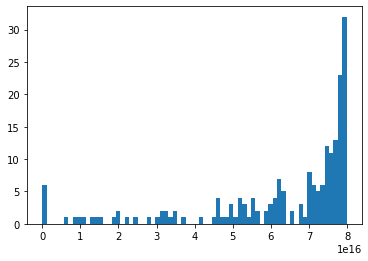

In [15]:
plt.hist(list(filter(lambda x: x > 500, maxs)),bins=70)
plt.show()

In [10]:
np.isnan(np.array(maxs)).mean() #4% nan

0.03848895224518888

Bei diesen 54 STORE:ITEM kombinationen stimmt etwas nicht. Vermutlich wurde maximal 1 Item verkauft, wodurch max() hier nan ausspuckt.

In [11]:
np.array(maxs).shape

(1403,)

Bei welchen Store Item Kombos war das denn der Fall?